In [1]:
!pip install --upgrade pandas pyarrow
!pip install skforecast

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster


# Lee el archivo .gzip que contiene el parquet directamente
df = pd.read_parquet('bermejales.gzip')

# Muestra las primeras filas de la tabla para verificar
print(df.head())

              datetime         co      no2      o3  pm10     tmp      vv
0  2005-01-01 00:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
1  2005-01-01 01:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
2  2005-01-01 02:00:00  2024.6667  26.6667  7.5000   NaN  6.6667  1.0000
3  2005-01-01 03:00:00  2229.3333  19.6667  5.5000   NaN  6.1667  0.3333
4  2005-01-01 04:00:00  2096.1667  19.5000  4.6667   NaN  5.3333  0.8333


## VARIABLES

### Contaminantes:

**NO2: (Dióxido de nitrógeno)**:
- Origen principal: Tráfico rodado y combustión (vehículos, calefacción, industria).
- Más alto en horas punta (7–9h, 18–20h) por tráfico.
- Más bajo por la noche y fines de semana.
- Relaciones:
    - Temperatura: tiende a disminuir cuando la temperatura sube, porque hay más mezcla del aire (dispersión vertical).

    - Viento (vv): el viento dispersa los contaminantes → a más viento, menos NO₂.

    - PM₁₀: correlación positiva, porque ambos suelen tener origen en el tráfico.

    - O₃: anticorrelación — el ozono se forma cuando los óxidos de nitrógeno (NOx) reaccionan con luz solar; si hay mucho NO₂, se “consume” ozono. Los picos de NO2 coinciden con los mínimos de O3.

**O3 (Ozono troposférico)**:

- No se emite directamente, se forma fotoquímicamente a partir de NO₂ + compuestos orgánicos volátiles bajo radiación solar.

- Mínimos de noche (sin luz solar).

- Máximos a mediodía y por la tarde (más radiación UV).

- Más alto en verano, más bajo en invierno.

- Relaciones:

    - Temperatura: más calor = más radiación y reacciones fotoquímicas → más O₃.

    - NO₂: relación inversa (NO consume O₃).

    - Viento: el viento puede diluir O₃ localmente, aunque también puede transportarlo desde otras zonas rurales.

    - PM₁₀: a veces correlaciona en verano (ambos altos por condiciones estables).

**PM10 (Material particulado ≤10 μm)**:

- Origen: tráfico (frenado, desgaste), polvo en suspensión, calefacción, industria.

- Relaciones:

    - Viento: suele disminuir con viento fuerte (dispersión), pero si el viento viene de zonas áridas puede aumentarlo (polvo sahariano).

    - Temperatura: en días fríos con inversión térmica, el aire se estratifica → aumenta PM₁₀ (no se dispersa).

    - NO₂: suelen correlacionar (ambos del tráfico).

    - O₃: a veces correlación positiva en verano (ambos asociados a alta radiación y estabilidad atmosférica).


### Variables adicionales:

**Temperatura (tmp)**:

- Relaciones típicas:

    - Con NO₂ y PM₁₀ en invierno → más calor → más dispersión → menos contaminantes.

    - Con O₃ → más calor → más formación fotoquímica.

    - A menudo se ve que los contaminantes primarios bajan con la temperatura, mientras que los secundarios (como O₃) suben.

**Viento (vv)**:
- Efecto general: dispersa contaminantes → reduce concentraciones locales.
- Relaciones:
    - Disminuye las concentraciones de NO₂ y PM₁₀.

    - Puede aumentar la de O₃ si el viento proviene de zonas donde se genera.

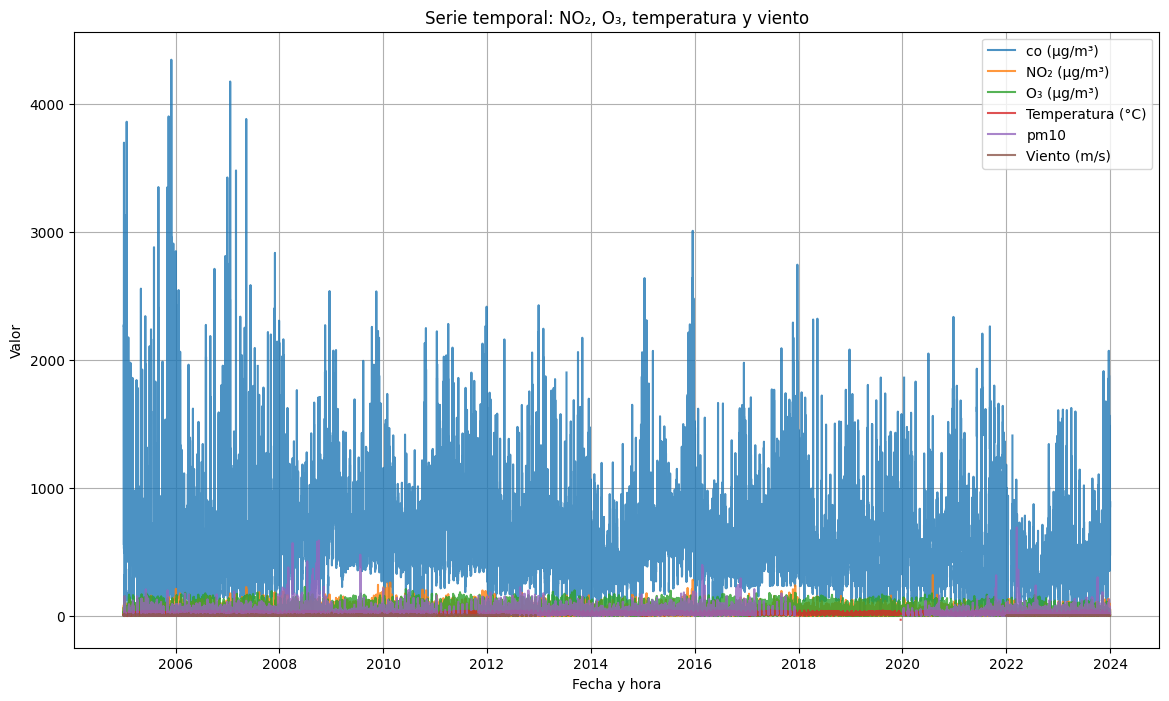

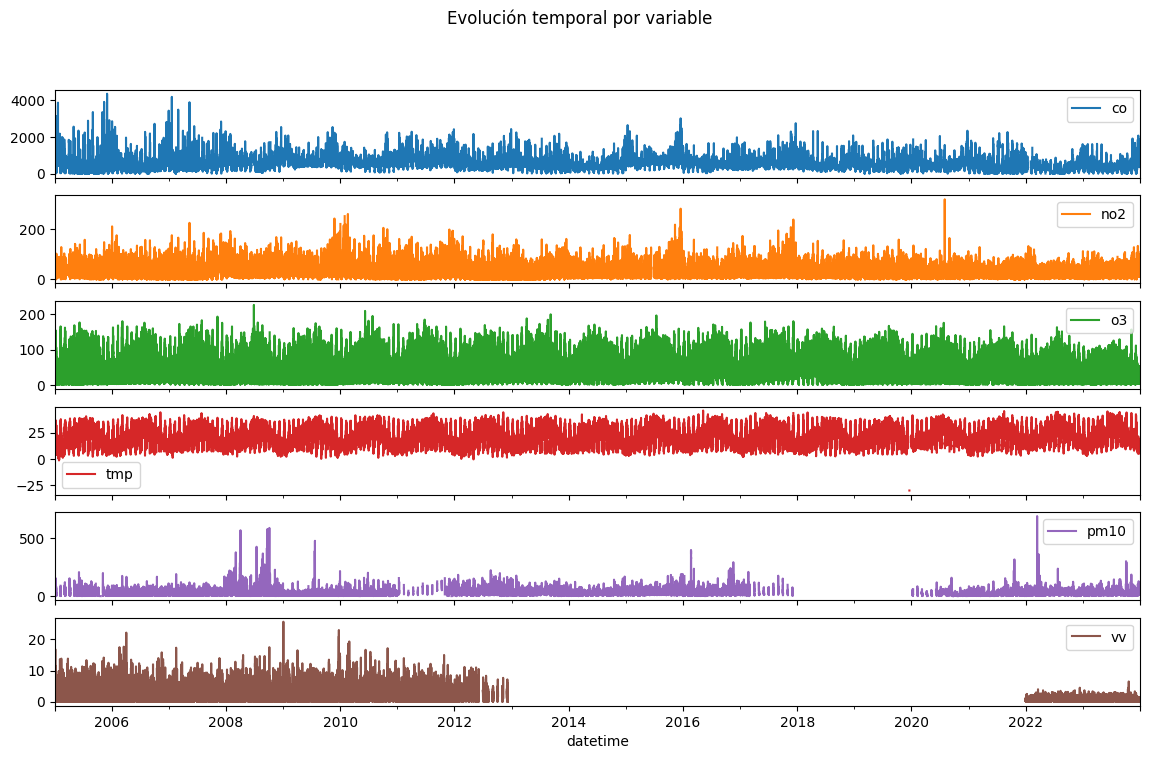

In [3]:
# --- 2. Convertir la columna datetime a tipo fecha ---
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# --- 3. Definir columna temporal como índice ---
df = df.set_index('datetime')

# --- 4. Visualización general ---
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['co'], label='co (µg/m³)', alpha=0.8)
plt.plot(df.index, df['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df.index, df['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df.index, df['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df.index, df['pm10'], label='pm10', alpha=0.8)
plt.plot(df.index, df['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal: NO₂, O₃, temperatura y viento')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Subgráficos por variable ---
variables = ['co', 'no2', 'o3', 'tmp','pm10', 'vv']
df[variables].plot(subplots=True, figsize=(14, 8), sharex=True, title='Evolución temporal por variable')
plt.show()


Mostrando datos desde 2023-12-24 hasta 2023-12-31


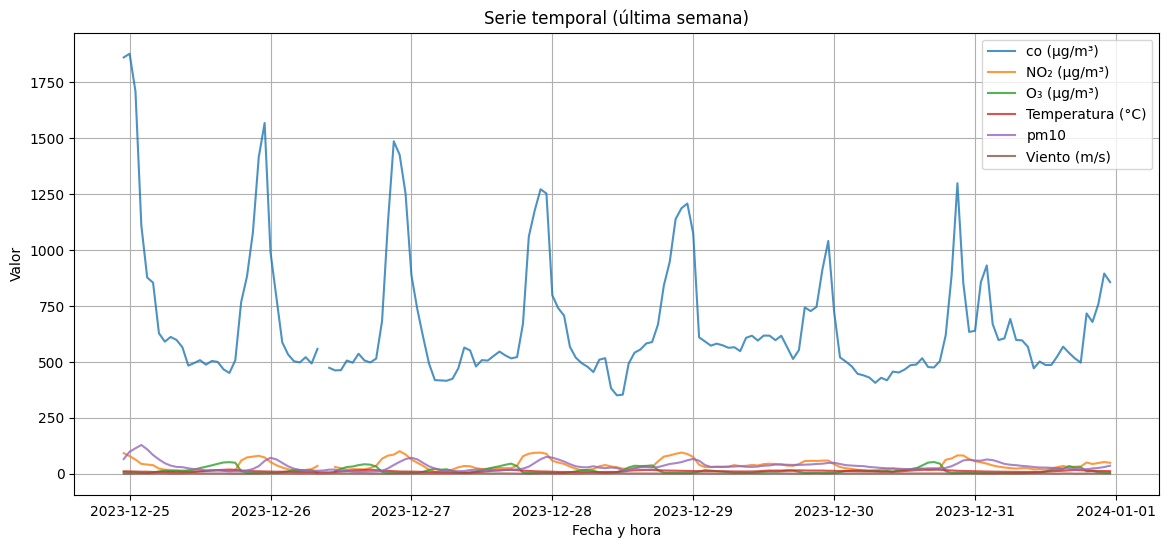

In [4]:
ultima_fecha = df.index.max()
inicio_semana = ultima_fecha - pd.Timedelta(days=7)
df_semana = df.loc[inicio_semana:ultima_fecha]

print(f"Mostrando datos desde {inicio_semana.date()} hasta {ultima_fecha.date()}")

# --- 🔹 Graficar las variables principales ---
plt.figure(figsize=(14, 6))
plt.plot(df_semana.index, df_semana['co'], label='co (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_semana.index, df_semana['pm10'], label='pm10', alpha=0.8)
plt.plot(df_semana.index, df_semana['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal (última semana)')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

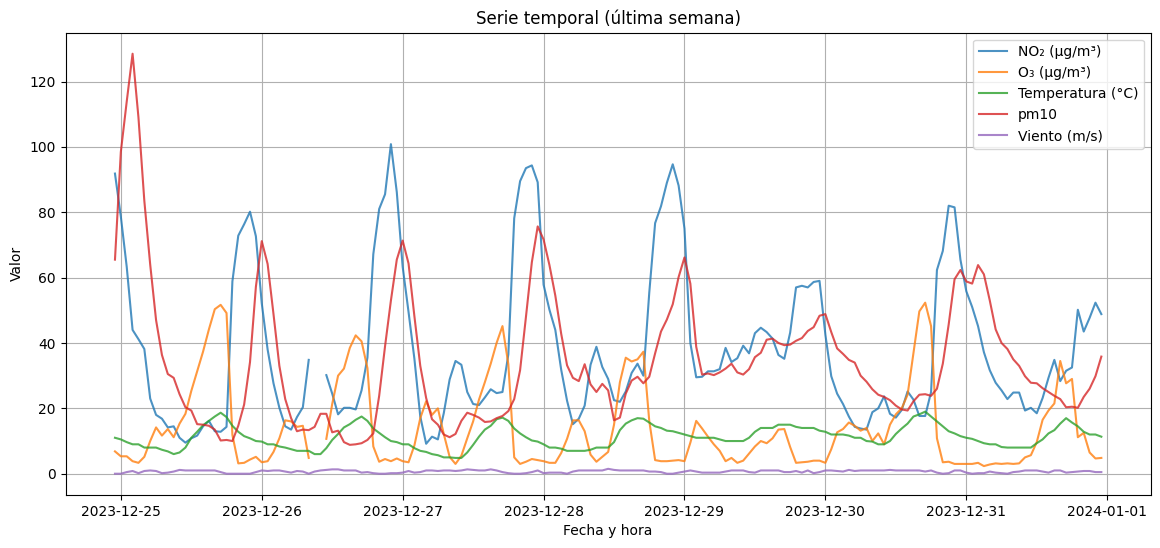

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df_semana.index, df_semana['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_semana.index, df_semana['pm10'], label='pm10', alpha=0.8)
plt.plot(df_semana.index, df_semana['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal (última semana)')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
df

,co,no2,o3,pm10,tmp,vv
datetime,,,,,,
2005-01-01 00:00:00,2269.0000,18.6667,2.5000,NaN,6.0000,0.3333
2005-01-01 01:00:00,2269.0000,18.6667,2.5000,NaN,6.0000,0.3333
2005-01-01 02:00:00,2024.6667,26.6667,7.5000,NaN,6.6667,1.0000
2005-01-01 03:00:00,2229.3333,19.6667,5.5000,NaN,6.1667,0.3333
2005-01-01 04:00:00,2096.1667,19.5000,4.6667,NaN,5.3333,0.8333
...,...,...,...,...,...,...
2023-12-31 19:00:00,716.8333,50.1667,11.1667,20.1667,14.5000,0.6667
2023-12-31 20:00:00,678.6667,43.5000,12.5000,23.5000,12.8333,0.8333
2023-12-31 21:00:00,758.8333,47.6667,6.5000,26.0000,12.0000,0.8333


In [7]:
ultima_fecha = df.index.max()
inicio_2021 = ultima_fecha - pd.Timedelta(days=730)
df_year = df.loc[inicio_2021:ultima_fecha]

In [8]:
df_year.isna().sum()

co      2595
no2      701
o3       132
pm10     145
tmp        2
vv         4
dtype: int64

### 2021 a 2023

In [9]:


df_last = df.truncate(before = '2022-01-01 00:00:00', after= '2023-12-31 23:00:00')

In [10]:
df_last

,co,no2,o3,pm10,tmp,vv
datetime,,,,,,
2022-01-01 00:00:00,467.3333,24.0000,20.0000,39.6667,14.6667,NaN
2022-01-01 01:00:00,NaN,15.1667,23.5000,49.5000,14.5000,1.0000
2022-01-01 02:00:00,NaN,31.3333,6.8333,85.0000,13.1667,0.1667
2022-01-01 03:00:00,NaN,23.0000,14.6667,96.1667,13.0000,1.0000
2022-01-01 04:00:00,NaN,9.5000,25.1667,77.8333,13.0000,1.0000
...,...,...,...,...,...,...
2023-12-31 19:00:00,716.8333,50.1667,11.1667,20.1667,14.5000,0.6667
2023-12-31 20:00:00,678.6667,43.5000,12.5000,23.5000,12.8333,0.8333
2023-12-31 21:00:00,758.8333,47.6667,6.5000,26.0000,12.0000,0.8333


In [11]:
df_last.isna().sum(), df_last.shape

(co      2595
 no2      701
 o3       132
 pm10     145
 tmp        2
 vv         3
 dtype: int64,
 (17520, 6))

In [12]:
# 1.3 comprobar frecuencia y huecos
print("Frecuencia inferida:", pd.infer_freq(df_last.index))
# mostrar primeras/últimas filas y huecos
print(df_last.head())
print(df_last.tail())


Frecuencia inferida: h
                           co      no2       o3     pm10      tmp      vv
datetime                                                                 
2022-01-01 00:00:00  467.3333  24.0000  20.0000  39.6667  14.6667     NaN
2022-01-01 01:00:00       NaN  15.1667  23.5000  49.5000  14.5000  1.0000
2022-01-01 02:00:00       NaN  31.3333   6.8333  85.0000  13.1667  0.1667
2022-01-01 03:00:00       NaN  23.0000  14.6667  96.1667  13.0000  1.0000
2022-01-01 04:00:00       NaN   9.5000  25.1667  77.8333  13.0000  1.0000
                           co      no2       o3     pm10      tmp      vv
datetime                                                                 
2023-12-31 19:00:00  716.8333  50.1667  11.1667  20.1667  14.5000  0.6667
2023-12-31 20:00:00  678.6667  43.5000  12.5000  23.5000  12.8333  0.8333
2023-12-31 21:00:00  758.8333  47.6667   6.5000  26.0000  12.0000  0.8333
2023-12-31 22:00:00  895.3333  52.3333   4.6667  29.8333  12.0000  0.5000
2023-12-31 23:0

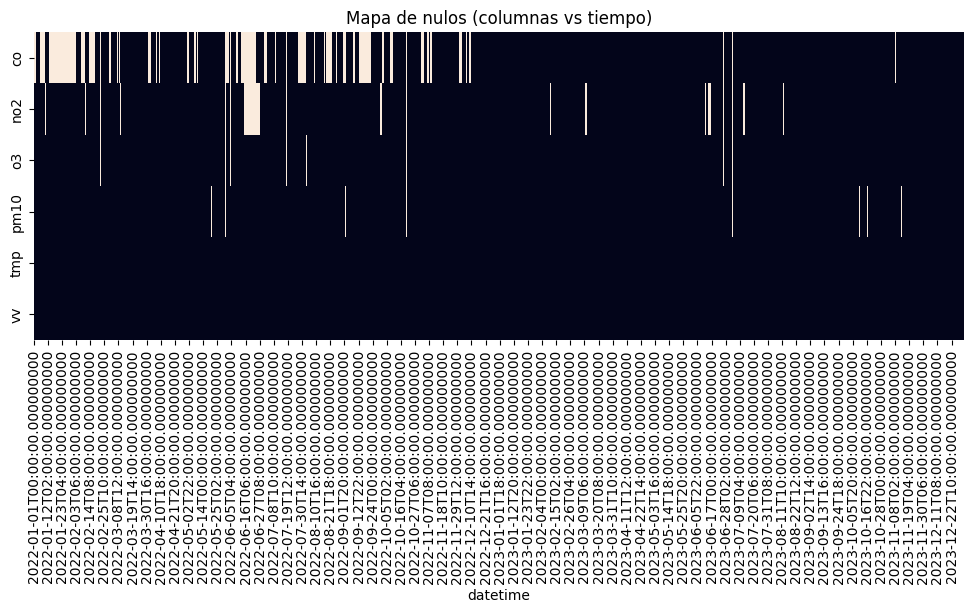

In [13]:
import seaborn as sns
plt.figure(figsize=(12,4))
sns.heatmap(df_last.isna().T, cbar=False)
plt.title('Mapa de nulos (columnas vs tiempo)')
plt.show()

In [14]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# 4.1: Imputación rápida para huecos pequeños con interpolación por columna
df_interp = df_last.copy()
df_interp = df_interp.drop(columns=['co'])
for col in df_interp.columns:
    # interpolación temporal; limit=6 -> no imputa tramos mayores a 6 horas (ajusta)
    df_interp[col] = df_interp[col].interpolate(method='time', limit=6)


print(df_interp.isna().sum())

# 4.2: Para huecos más largos, usar IterativeImputer (e.g. BayesianRidge pred) o KNN
# crear features de tiempo para ayudar a imputar

df_imp = df_interp.copy()
df_imp['hour'] = df_imp.index.hour
df_imp['dayofweek'] = df_imp.index.dayofweek
df_imp['month'] = df_imp.index.month

# Imputador iterativo (puede ser más robusto que KNN)
imp = IterativeImputer(random_state=0, max_iter=10)
cols = ['no2','o3','pm10','tmp','vv','hour','dayofweek','month']
imputed = imp.fit_transform(df_imp[cols])
df_imputed = pd.DataFrame(imputed, index=df_imp.index, columns=cols)

# Volver a asignar sólo las variables originales (no los features)

no2     504
o3        0
pm10     36
tmp       0
vv        1
dtype: int64


In [15]:
df_imputed.isna().sum()

no2          0
o3           0
pm10         0
tmp          0
vv           0
hour         0
dayofweek    0
month        0
dtype: int64

### Serie con nulos imputados

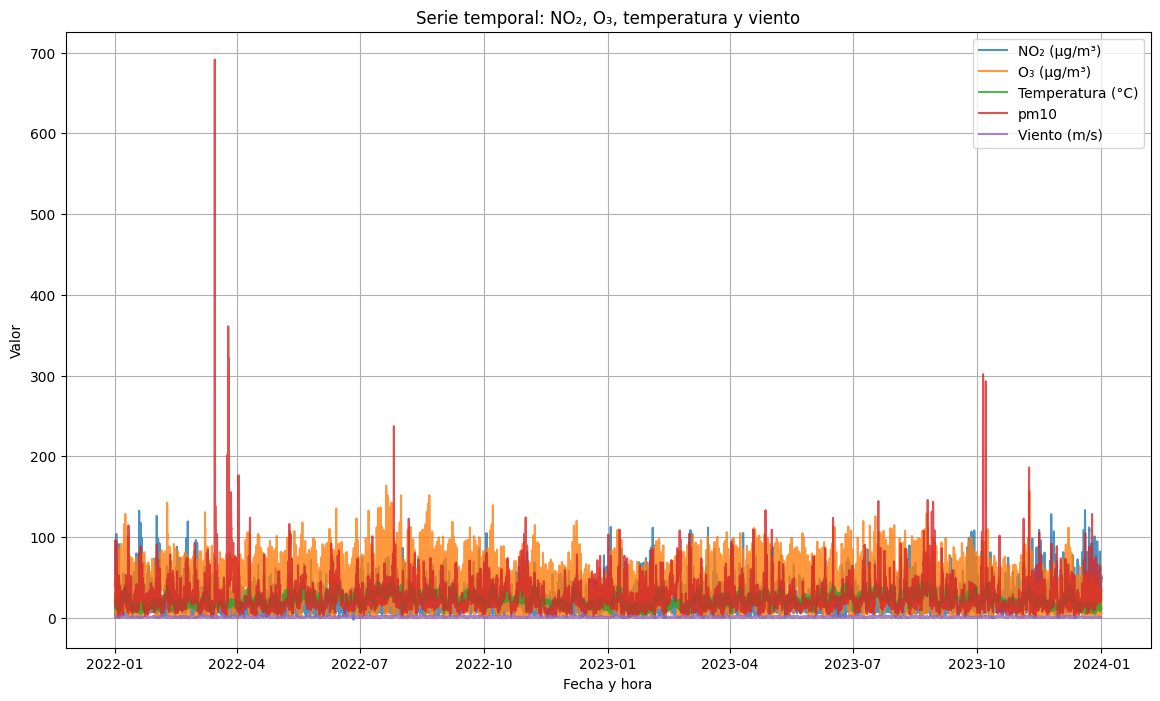

In [16]:
plt.figure(figsize=(14, 8))
plt.plot(df_imputed.index, df_imputed['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['pm10'], label='pm10', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal: NO₂, O₃, temperatura y viento')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

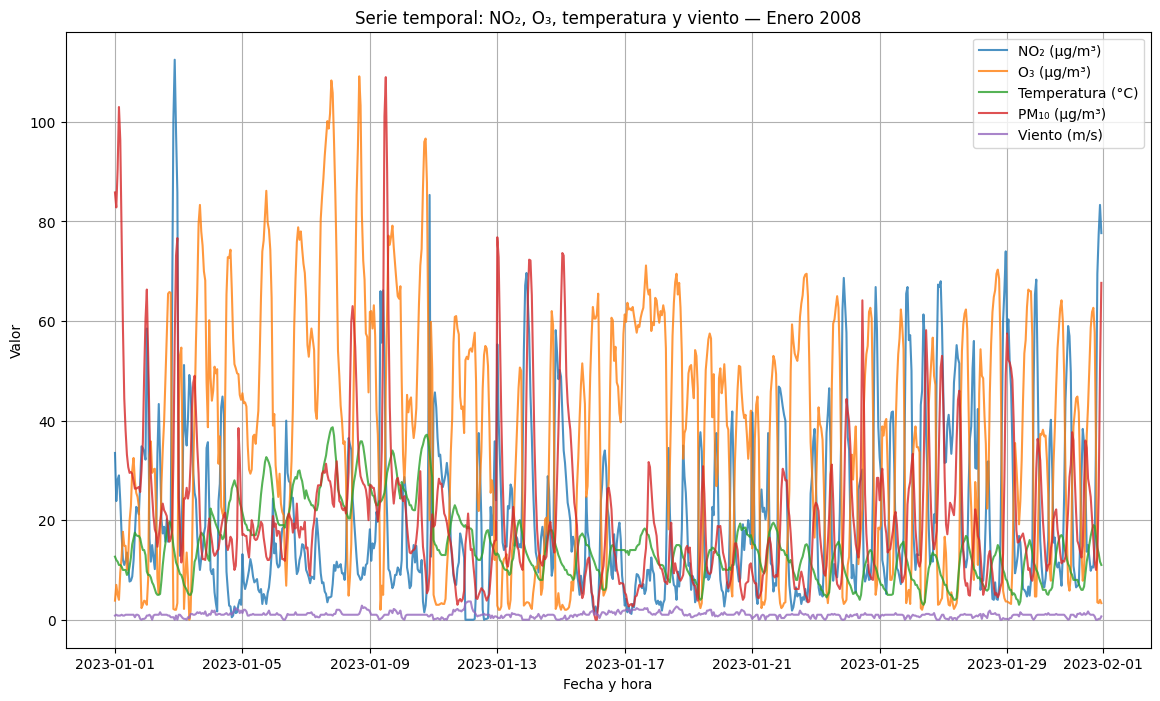

In [17]:
df_mes = df_imputed.loc['2023-01-01':'2023-01-31']

plt.figure(figsize=(14, 8))
plt.plot(df_mes.index, df_mes['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_mes.index, df_mes['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_mes.index, df_mes['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_mes.index, df_mes['pm10'], label='PM₁₀ (µg/m³)', alpha=0.8)
plt.plot(df_mes.index, df_mes['vv'], label='Viento (m/s)', alpha=0.8)

plt.title('Serie temporal: NO₂, O₃, temperatura y viento — Enero 2008')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def cap_outliers(s, k=1.5):
    q1 = df_imputed[s].quantile(0.25)
    q3 = df_imputed[s].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    outliers = df_imputed[(df_imputed[s] < lower) | (df_imputed[s] > upper)]
    print('Outliers en '+str(s)+ ' ' + str(len(outliers)))

cols_to_check = ['no2', 'pm10', 'tmp', 'vv', 'o3']
for col in cols_to_check:
    cap_outliers(col)


Outliers en no2 885
Outliers en pm10 1019
Outliers en tmp 40
Outliers en vv 3471
Outliers en o3 66


### NORMALIZACION

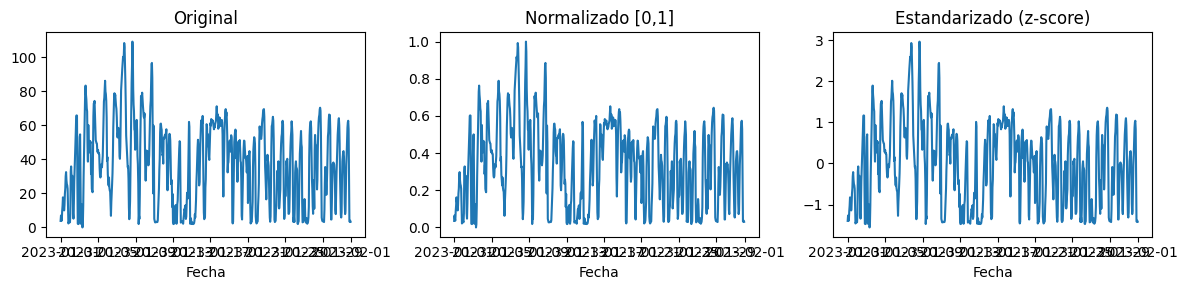

,o3,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,37.589829,0.344334,-2.865092e-17
std,24.189330,0.221582,1.000673e+00
min,0.000000,0.000000,-1.555029e+00
25%,14.875000,0.136260,-9.396751e-01
50%,38.833300,0.355725,5.144033e-02
75%,56.374975,0.516412,7.771105e-01
max,109.166700,1.000000,2.961017e+00


In [19]:
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

df_mes = df_imputed.loc['2023-01-01':'2023-01-31']
# Trabajamos sobre una copia para no tocar
df = df_mes.copy()
columna = 'o3'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

### MODELO BASE AUTOREGRESIVO SIN EXOGENAS:

La variable que queremos predecir es el ozono `O3`

In [28]:
df_imputed

,no2,o3,pm10,tmp,vv,hour,dayofweek,month
datetime,,,,,,,,
2022-01-01 00:00:00,24.0000,20.0000,39.6667,14.6667,0.661828,0.0,5.0,1.0
2022-01-01 01:00:00,15.1667,23.5000,49.5000,14.5000,1.000000,1.0,5.0,1.0
2022-01-01 02:00:00,31.3333,6.8333,85.0000,13.1667,0.166700,2.0,5.0,1.0
2022-01-01 03:00:00,23.0000,14.6667,96.1667,13.0000,1.000000,3.0,5.0,1.0
2022-01-01 04:00:00,9.5000,25.1667,77.8333,13.0000,1.000000,4.0,5.0,1.0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,50.1667,11.1667,20.1667,14.5000,0.666700,19.0,6.0,12.0
2023-12-31 20:00:00,43.5000,12.5000,23.5000,12.8333,0.833300,20.0,6.0,12.0
2023-12-31 21:00:00,47.6667,6.5000,26.0000,12.0000,0.833300,21.0,6.0,12.0


In [ ]:
df_2y= df_imputed.loc['2022-01-01':'2023-12-17']
df_test = df_imputed.loc['2023-12-18':'2022-12-31']
y = df_2y['o3'].astype(float)

In [27]:
y

datetime
2023-01-01 00:00:00     3.8333
2023-01-01 01:00:00     7.0000
2023-01-01 02:00:00     5.0000
2023-01-01 03:00:00     4.0000
2023-01-01 04:00:00     9.5000
                        ...   
2023-03-31 19:00:00    48.3333
2023-03-31 20:00:00    46.0000
2023-03-31 21:00:00    44.8333
2023-03-31 22:00:00    35.8333
2023-03-31 23:00:00    45.1667
Name: o3, Length: 2160, dtype: float64

Tamaño: (2160,)
Nulos: 0


count    2160.000000
mean       42.331674
std        24.874078
min         0.000000
25%        22.833300
50%        43.166700
75%        60.500000
max       109.166700
Name: o3, dtype: float64

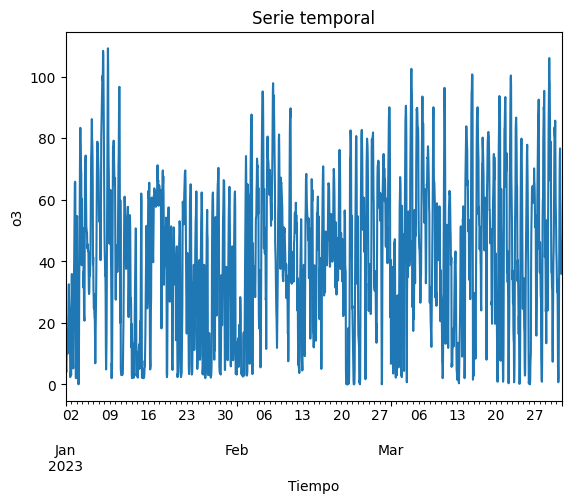

In [23]:
print("Tamaño:", y.shape)
print("Nulos:", int(y.isna().sum()))
display(y.describe())

# Relleno simple si hay nulos
if y.isna().any():
    y = y.interpolate().bfill()

ax = y.plot(title='Serie temporal')
ax.set_xlabel('Tiempo'); ax.set_ylabel('o3')
plt.show()

train:(1944,), valid:(108,), test:(108,)


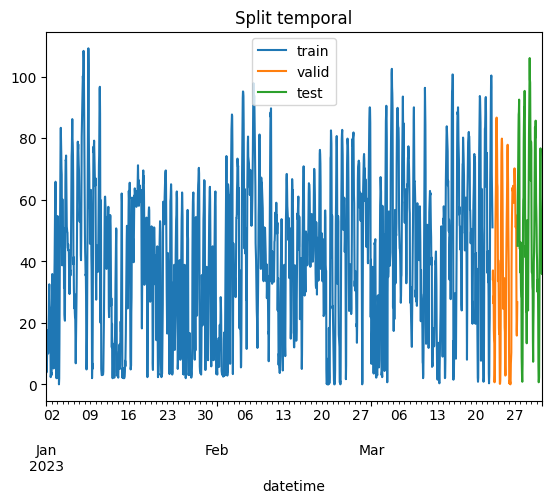

In [70]:
# 5) Split y CV
n = len(y)
train_end = int(0.90*n)
valid_end = int(0.95*n)

y_train = y.iloc[:train_end]
y_valid = y.iloc[train_end:valid_end]
y_test  = y.iloc[valid_end:]

print(f"train:{y_train.shape}, valid:{y_valid.shape}, test:{y_test.shape}")

ax = y_train.plot(label='train')
y_valid.plot(ax=ax, label='valid')
y_test.plot(ax=ax, label='test', title='Split temporal')
ax.legend(); plt.show()


In [73]:
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
# 1) Serie numérica ordenada
y = y.astype(float).sort_index()

# 2) Inferir frecuencia; si existe, regularizar con asfreq
freq = pd.infer_freq(y.index)

if freq is not None:
    y = y.asfreq(freq)
if freq is not None:
    y_train.index = pd.DatetimeIndex(y_train.index, freq=freq)
    y_valid.index = pd.DatetimeIndex(y_valid.index, freq=freq)
else:
    print('⚠️ Serie sin frecuencia inferible. Puedes usar ignore_freq=True en fit/backtesting.')


print(f'Freq: {freq}')
print(f'Train: {y_train.index[0].date()} → {y_train.index[-1].date()} (n={len(y_train)})')
print(f'Valid: {y_valid.index[0].date()} → {y_valid.index[-1].date()} (n={len(y_valid)})')

cv = TimeSeriesFold(
    steps=len(y_valid),
    initial_train_size=len(y) - len(y_valid),
    fixed_train_size=True
)
cv

Freq: h
Train: 2023-01-01 → 2023-03-22 (n=1944)
Valid: 2023-03-23 → 2023-03-27 (n=108)


============== 
TimeSeriesFold 
============== 
Initial train size    = 2052,
Steps                 = 108,
Fold stride           = 108,
Overlapping folds     = False,
Window size           = None,
Differentiation       = None,
Refit                 = False,
Fixed train size      = True,
Gap                   = 0,
Skip folds            = None,
Allow incomplete fold = True,
Return all indexes    = False,
Verbose               = True

In [72]:
def tune_model(y, regressor, param_grid, lags_grid, cv, metric='mean_absolute_error', ignore_freq=None):
    """
    Ejecuta grid_search_forecaster() y devuelve SIEMPRE:
      - results_df: DataFrame con combinaciones evaluadas
      - f_best: ForecasterRecursive ajustado con la mejor configuración
    Compatible con variantes que devuelven dict o DataFrame.
    """
    f = ForecasterRecursive(regressor=regressor, lags=lags_grid[0] if len(lags_grid) else 12)
    kwargs = dict(
        forecaster=f, y=y, cv=cv, lags_grid=lags_grid, param_grid=param_grid,
        metric=metric, return_best=True, verbose=False
    )
    if ignore_freq:
        kwargs['ignore_freq'] = True

    out = grid_search_forecaster(**kwargs)

    if isinstance(out, dict) and 'results' in out and 'forecaster' in out:
        results_df, f_best = out['results'], out['forecaster']
    else:
        results_df, f_best = out, f  # algunas versiones devuelven DF y modifican f in-place

    return results_df, f_best


def backtest_best(f_best, y, cv, metric='mean_absolute_error', ignore_freq=None):
    """
    Devuelve:
      - metrics_out: métricas por split (tipo varía por versión)
      - preds_out: DF de predicciones o None
    Soporta API con/sin 'return_predict'.
    """
    kwargs = dict(forecaster=f_best, y=y, cv=cv, metric=metric, verbose=False)
    if ignore_freq:
        kwargs['ignore_freq'] = True

    try:
        metrics_out, preds_out = backtesting_forecaster(return_predict=True, **kwargs)
    except TypeError:
        out = backtesting_forecaster(**kwargs)
        if isinstance(out, tuple) and len(out) == 2:
            metrics_out, preds_out = out
        else:
            metrics_out, preds_out = out, None
    return metrics_out, preds_out


def extract_mae(metrics_out, metric_name='mean_absolute_error'):
    """Extrae un MAE medio de la salida de métricas, sea float/Series/DataFrame."""
    import numpy as _np
    import pandas as _pd
    if isinstance(metrics_out, (float, int, _np.floating, _np.integer)):
        return float(metrics_out)
    if isinstance(metrics_out, _pd.Series):
        return float(_pd.to_numeric(metrics_out, errors='coerce').mean())
    if isinstance(metrics_out, _pd.DataFrame):
        df = metrics_out.copy()
        if {'metric','value'}.issubset(df.columns):
            mask = (df['metric'] == metric_name)
            if mask.any():
                return float(_pd.to_numeric(df.loc[mask, 'value'], errors='coerce').mean())
            return float(_pd.to_numeric(df['value'], errors='coerce').mean())
        if metric_name in df.columns:
            return float(_pd.to_numeric(df[metric_name], errors='coerce').mean())
        if 'value' in df.columns:
            return float(_pd.to_numeric(df['value'], errors='coerce').mean())
        num = df.select_dtypes(include=_np.number)
        if not num.empty:
            return float(num.iloc[:, 0].mean())
    raise ValueError('Formato de métricas no reconocido para extraer MAE.')

In [74]:

# === Rejillas y ejecución de tuning ===

ridge = Ridge(random_state=0)
tree  = DecisionTreeRegressor(random_state=0)
rf    = RandomForestRegressor(random_state=0, n_estimators=200, n_jobs=-1)

lags_grid = [24, 48, 72, 168]
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
param_grid_tree  = {'max_depth': [3, 5, 8, None]}
param_grid_rf    = {'n_estimators': [200, 400], 'max_depth': [5, 10, None]}

print('🔎 Tuning Ridge...')
ridge_results, f_ridge_best = tune_model(y, ridge, param_grid_ridge, lags_grid, cv)

print('🔎 Tuning Decision Tree...')
tree_results,  f_tree_best  = tune_model(y, tree,  param_grid_tree,  lags_grid, cv)

print('🔎 Tuning Random Forest...')
rf_results,    f_rf_best    = tune_model(y, rf,    param_grid_rf,    lags_grid, cv)

# Vista previa de resultados de Ridge
ridge_results.head()

🔎 Tuning Ridge...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 12.01158862685564
🔎 Tuning Decision Tree...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'max_depth': None}
  Backtesting metric: 19.529325925925924
🔎 Tuning Random Forest...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 18.96506621826411


,lags,lags_label,params,mean_absolute_error,alpha
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 10.0},12.011589,10.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1.0},12.011781,1.0
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},12.011801,0.1
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 10.0},13.676882,10.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1.0},13.676951,1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Comparación de MAE (promedio CV):


,modelo,mae_cv
0,Ridge,12.011589
2,RandomForest,18.965066
1,DecisionTree,19.529326


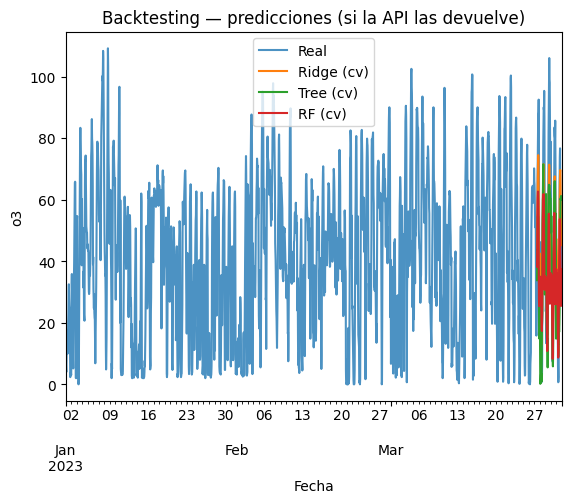

In [75]:
# === Backtesting con los mejores modelos ===

m_ridge, p_ridge = backtest_best(f_ridge_best, y, cv)
m_tree,  p_tree  = backtest_best(f_tree_best,  y, cv)
m_rf,    p_rf    = backtest_best(f_rf_best,    y, cv)

# Comparación de MAE (promedio)
compare = pd.DataFrame({
    'modelo': ['Ridge', 'DecisionTree', 'RandomForest'],
    'mae_cv': [
        extract_mae(m_ridge, 'mean_absolute_error'),
        extract_mae(m_tree,  'mean_absolute_error'),
        extract_mae(m_rf,    'mean_absolute_error'),
    ]
}).sort_values('mae_cv')

print('Comparación de MAE (promedio CV):')
display(compare)

# Intentar graficar predicciones (si existen) del último tramo
def plot_cv_preds(preds, label):
    if preds is None or not isinstance(preds, pd.DataFrame):
        return False
    for col in ['pred', 'prediction', 'y_pred', 'forecast']:
        if col in preds.columns:
            preds[col].plot(label=label)
            return True
    return False

plt.figure()
y.plot(label='Real', alpha=0.8)
ok = False
ok |= plot_cv_preds(p_ridge, 'Ridge (cv)')
ok |= plot_cv_preds(p_tree,  'Tree (cv)')
ok |= plot_cv_preds(p_rf,    'RF (cv)')
plt.title('Backtesting — predicciones (si la API las devuelve)' if ok else
          'Backtesting — la API no devolvió predicciones (solo valores reales)')
plt.xlabel('Fecha'); plt.ylabel('o3')
plt.legend(); plt.show()

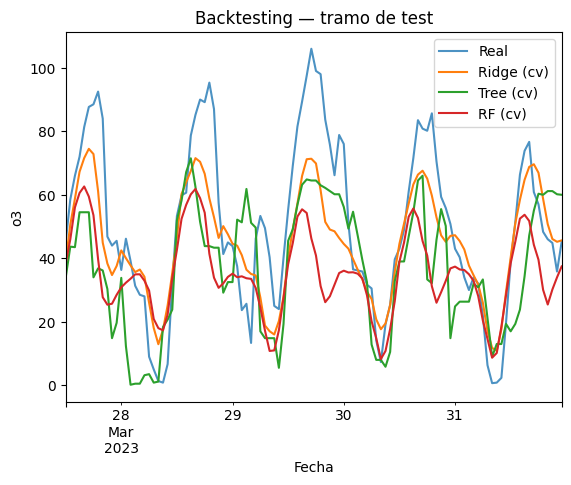

In [77]:
plt.figure()

# Determinar el rango temporal mínimo y máximo de las predicciones
fechas_min = min(df.index.min() for df in [p_ridge, p_tree, p_rf] if df is not None)
fechas_max = max(df.index.max() for df in [p_ridge, p_tree, p_rf] if df is not None)

# Recortar y al rango de test
y.loc[fechas_min:fechas_max].plot(label='Real', alpha=0.8)

ok = False
ok |= plot_cv_preds(p_ridge, 'Ridge (cv)')
ok |= plot_cv_preds(p_tree,  'Tree (cv)')
ok |= plot_cv_preds(p_rf,    'RF (cv)')

plt.title('Backtesting — tramo de test' if ok else 'No hay predicciones')
plt.xlabel('Fecha')
plt.ylabel('o3')
plt.legend()
plt.show()

Añadir variables exogenas:

In [78]:
df_3mes

,no2,o3,pm10,tmp,vv,hour,dayofweek,month
datetime,,,,,,,,
2023-01-01 00:00:00,33.5000,3.8333,85.8333,12.6667,0.8333,0.0,6.0,1.0
2023-01-01 01:00:00,23.8333,7.0000,82.8333,12.0000,1.0000,1.0,6.0,1.0
2023-01-01 02:00:00,28.1667,5.0000,90.5000,11.6667,0.8333,2.0,6.0,1.0
2023-01-01 03:00:00,29.0000,4.0000,103.0000,11.0000,0.8333,3.0,6.0,1.0
2023-01-01 04:00:00,23.8333,9.5000,96.3333,11.0000,0.8333,4.0,6.0,1.0
...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,6.8333,48.3333,15.3333,28.8333,1.3333,19.0,4.0,3.0
2023-03-31 20:00:00,9.6667,46.0000,21.5000,27.3333,1.0000,20.0,4.0,3.0
2023-03-31 21:00:00,8.6667,44.8333,24.3333,25.3333,1.1667,21.0,4.0,3.0


In [79]:
df_3mes = df_imputed.loc['2023-01-01':'2023-03-31']
y = df_3mes['o3'].astype(float)
X = df_3mes.drop(columns=['o3'])

In [83]:
# 2) Inferir frecuencia; si existe, regularizar con asfreq
freq = pd.infer_freq(y.index)

if freq is not None:
    y = y.asfreq(freq)
if freq is not None:
    y_train.index = pd.DatetimeIndex(y_train.index, freq=freq)
    y_valid.index = pd.DatetimeIndex(y_valid.index, freq=freq)
else:
    print('⚠️ Serie sin frecuencia inferible. Puedes usar ignore_freq=True en fit/backtesting.')


In [84]:
n = len(y)
train_end = int(0.90*n)
valid_end = int(0.95*n)

y_train = y.iloc[:train_end]
y_valid = y.iloc[train_end:valid_end]
y_test  = y.iloc[valid_end:]

X_train = X.loc[y_train.index]
X_valid = X.loc[y_valid.index]
X_test  = X.loc[y_test.index]

In [85]:
# Número de lags para el target
lags_exog = 168   # puedes probar 12, 24, 48, 168

# Definición del forecaster
forecaster_exog = ForecasterRecursive(
    regressor=Ridge(random_state=0),
    lags=lags_exog
)

# Entrenamiento (usa ignore_freq=True si el índice no tiene freq)
forecaster_exog.fit(y=y_train, exog=X_train)

# Predicción sobre el tramo de validación
pred_exog = forecaster_exog.predict(steps=len(y_valid), exog=X_valid)

In [86]:
MAE_exog = mean_absolute_error(y_valid, pred_exog)
RMSE_exog = mean_squared_error(y_valid, pred_exog) ** 0.5

print(f"[BASE con exógenas] lags={lags_exog}  MAE={MAE_exog:.3f}  RMSE={RMSE_exog:.3f}")

[BASE con exógenas] lags=168  MAE=10.865  RMSE=13.690


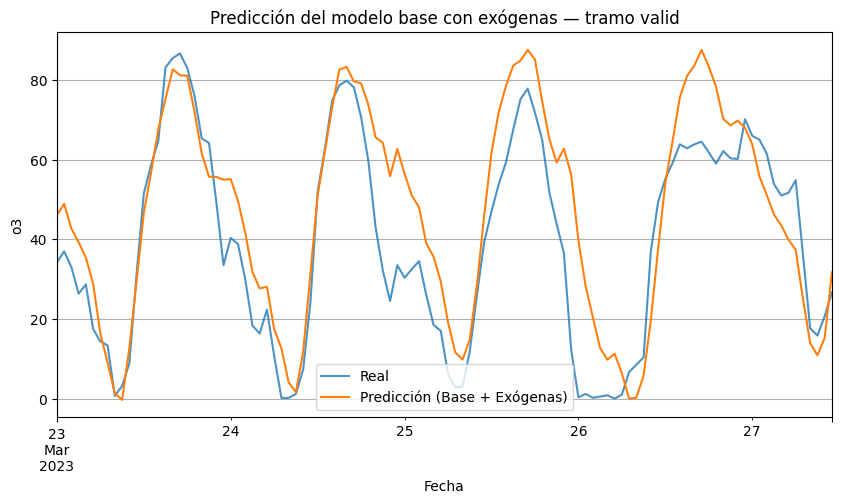

In [87]:
plt.figure(figsize=(10,5))
y_valid.plot(label='Real', color='tab:blue', alpha=0.8)
pred_exog.plot(label='Predicción (Base + Exógenas)', color='tab:orange')
plt.title('Predicción del modelo base con exógenas — tramo valid')
plt.xlabel('Fecha'); plt.ylabel('o3')
plt.legend(); plt.grid(True)
plt.show()


Entrenando modelo: Ridge

Entrenando modelo: DecisionTree

Entrenando modelo: RandomForest


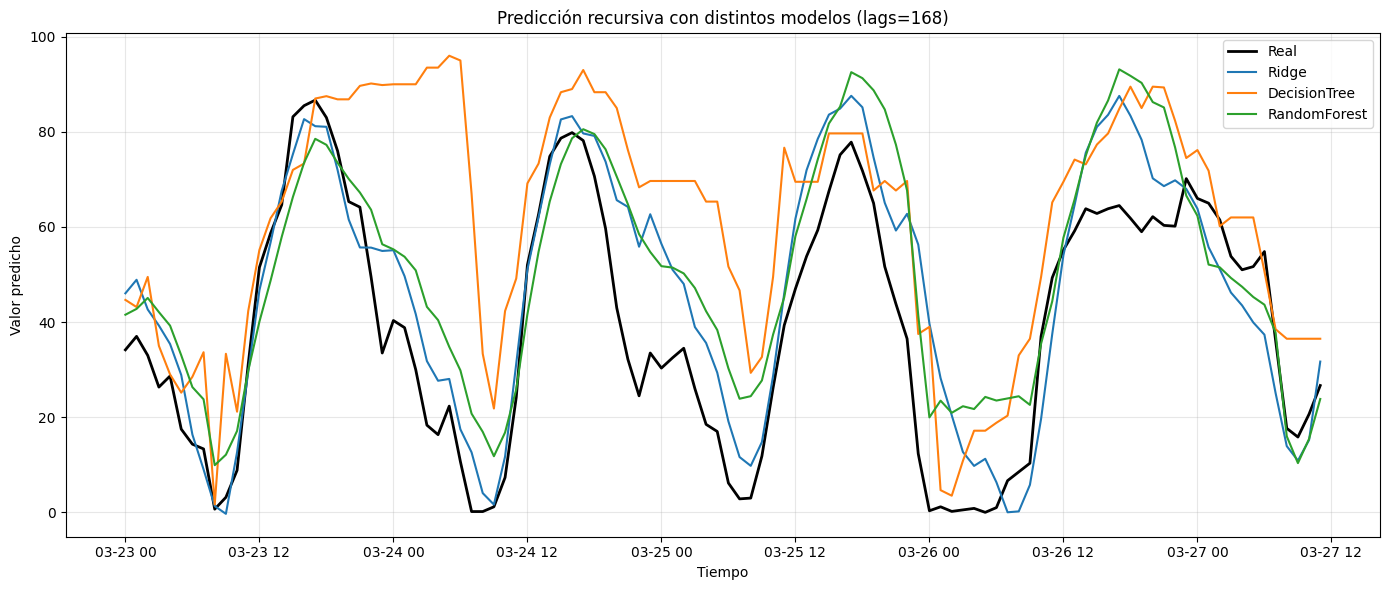

In [90]:
models = {
    'Ridge': Ridge(random_state=0),
    'DecisionTree': DecisionTreeRegressor(random_state=0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
}

# === ENTRENAMIENTO Y PREDICCIÓN ===
preds = {}

for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    forecaster = ForecasterRecursive(
        regressor=model,
        lags=lags_exog
    )

    # Entrenar (usa ignore_freq=True si tu índice no tiene freq)
    forecaster.fit(y=y_train, exog=X_train)

    # Predecir el tramo de validación
    preds[name] = forecaster.predict(steps=len(y_valid), exog=X_valid)

# === GRAFICAR ===
plt.figure(figsize=(14, 6))
plt.plot(y_valid.index, y_valid, label='Real', color='black', linewidth=2)

for name, pred in preds.items():
    plt.plot(y_valid.index, pred, label=name)

plt.title(f'Predicción recursiva con distintos modelos (lags={lags_exog})')
plt.xlabel('Tiempo')
plt.ylabel('Valor predicho')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### OTRA COSA

In [ ]:
def generar_atributos_desfase(ts_data, var, max_lag):
    """
    Crea columnas var_lag1, var_lag2, ..., var_lag{k} con shift(t).
    ts_data: DataFrame con índice temporal
    var:     nombre de la columna base (p.ej., 'Nivel')
    max_lag: número máximo de retardos
    """
    for t in range(1, max_lag + 1):
        ts_data[f'{var}_lag{t}'] = ts_data[var].shift(t)
    return ts_data
df = generar_atributos_desfase(df_No_exogenas.copy(), 'O3', max_lag=10)
display(df.tail(10))


,O3,O3_lag1,O3_lag2,O3_lag3,O3_lag4,O3_lag5,O3_lag6,O3_lag7,O3_lag8,O3_lag9,O3_lag10
datetime,,,,,,,,,,,
2008-01-31 14:00:00,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000,3.5000,9.6667,11.1667,3.3333,3.6667
2008-01-31 15:00:00,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000,3.5000,9.6667,11.1667,3.3333
2008-01-31 16:00:00,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000,3.5000,9.6667,11.1667
2008-01-31 17:00:00,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000,3.5000,9.6667
2008-01-31 18:00:00,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000,3.5000
2008-01-31 19:00:00,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000
2008-01-31 20:00:00,6.5000,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667
2008-01-31 21:00:00,1.6667,6.5000,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333
2008-01-31 22:00:00,2.1667,1.6667,6.5000,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000


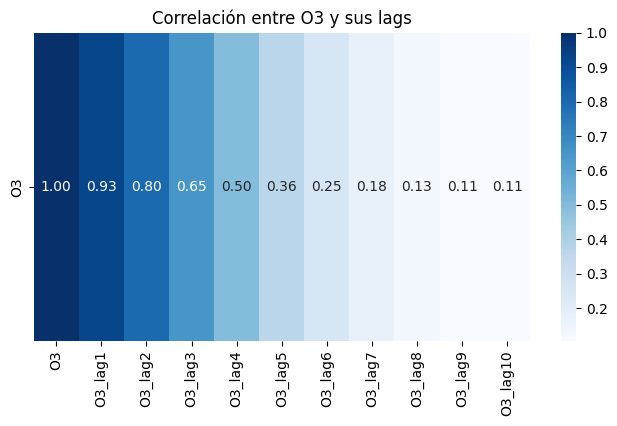

In [ ]:
# 4) Correlación de cada lag con la variable original (descartando NaN por lags)
lags_cols = [c for c in df.columns if c.startswith('O3_lag')]
corr = df[['O3'] + lags_cols].dropna().corr()['O3'].sort_values(ascending=False)
corr

# 5) Mapa de calor de correlaciones (Nivel vs. sus lags)
plt.figure(figsize=(8, 4))
sns.heatmap(
    df[['O3'] + lags_cols].dropna().corr()[['O3']].T,
    annot=True, cmap='Blues', fmt=".2f"
)
plt.title('Correlación entre O3 y sus lags')
plt.show()

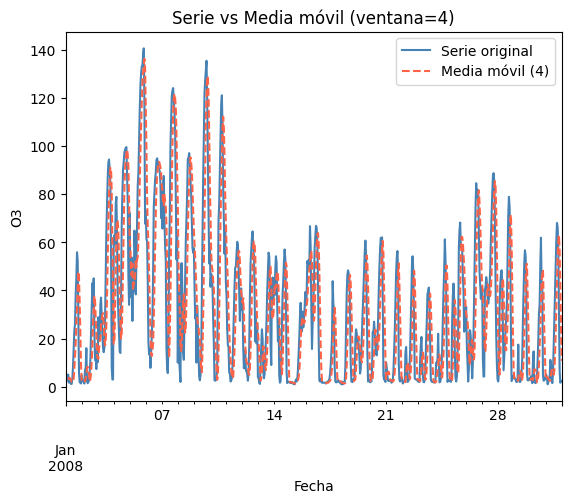

In [ ]:
# === Bloque 6: Ventanas deslizantes (rolling) — versión simple ===

df_rolling = df.copy()
columna = 'O3'   # cambia si tu variable principal tiene otro nombre

# 1) Media móvil (ventana 4), desplazando 1 paso para no usar el valor actual
df_rolling['media_movil_4'] = df_rolling[columna].shift(1).rolling(window=4).mean()

# 2) Otras estadísticas con la misma ventana
df_rolling['max_movil_4'] = df_rolling[columna].shift(1).rolling(window=4).max()
df_rolling['min_movil_4'] = df_rolling[columna].shift(1).rolling(window=4).min()
df_rolling['std_movil_4'] = df_rolling[columna].shift(1).rolling(window=4).std()

# 3) Vista rápida
df_rolling[[columna, 'media_movil_4', 'max_movil_4', 'min_movil_4', 'std_movil_4']].head(10)

# 4) Comparación visual: serie original vs media móvil (4)
ax = df_rolling[columna].plot(label='Serie original', color='steelblue')
df_rolling['media_movil_4'].plot(ax=ax, label='Media móvil (4)', color='tomato', linestyle='--')
ax.set_title('Serie vs Media móvil (ventana=4)')
ax.set_xlabel('Fecha'); ax.set_ylabel(columna)
ax.legend(); plt.show()

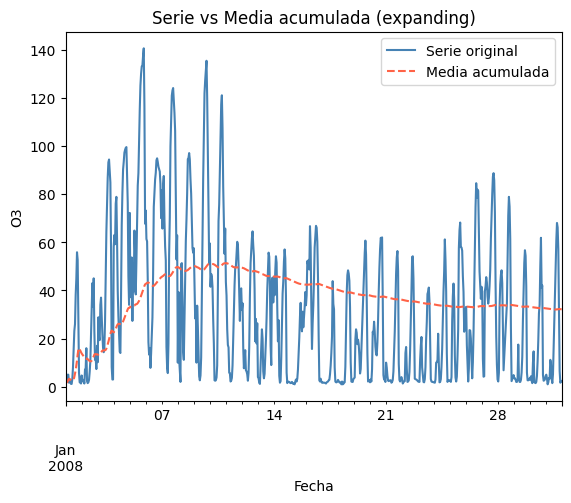

In [ ]:
# === Bloque 7: Ventanas ampliadas (expanding) — versión simple ===
import matplotlib.pyplot as plt

columna = 'O3'   # cambia si tu variable principal tiene otro nombre

# 1) Estadísticas acumuladas (memoria creciente) con shift(1)
df_rolling['media_acum'] = df_rolling[columna].shift(1).expanding().mean()
df_rolling['suma_acum']  = df_rolling[columna].shift(1).expanding().sum()
df_rolling['max_acum']   = df_rolling[columna].shift(1).expanding().max()
df_rolling['std_acum']   = df_rolling[columna].shift(1).expanding().std()

# 2) Extra robusto: mínimo acumulado y, si está disponible, cuartil 25% acumulado
df_rolling['min_acum']   = df_rolling[columna].shift(1).expanding().min()
try:
    df_rolling['q25_acum'] = df_rolling[columna].shift(1).expanding().quantile(0.25)
except Exception as e:
    # Algunas versiones de pandas no soportan quantile en expanding
    print('Cuartil acumulado no soportado en esta versión de pandas:', e)

# 3) Vista rápida
df_rolling[[columna, 'media_acum', 'suma_acum', 'max_acum', 'std_acum', 'min_acum']].head(10)

# 4) Comparación visual: serie original vs media acumulada
ax = df_rolling[columna].plot(label='Serie original', color='steelblue')
df_rolling['media_acum'].plot(ax=ax, label='Media acumulada', color='tomato', linestyle='--')
ax.set_title('Serie vs Media acumulada (expanding)')
ax.set_xlabel('Fecha'); ax.set_ylabel(columna)
ax.legend(); plt.show()


In [ ]:
df_rolling

,O3,O3_lag1,O3_lag2,O3_lag3,O3_lag4,O3_lag5,O3_lag6,O3_lag7,O3_lag8,O3_lag9,...,media_movil_4,max_movil_4,min_movil_4,std_movil_4,media_acum,suma_acum,max_acum,std_acum,min_acum,q25_acum
datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00,1.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 01:00:00,2.0000,1.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.666700,1.66670,1.6667,NaN,1.6667,1.666700
2008-01-01 02:00:00,2.8333,2.0000,1.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.833350,3.66670,2.0000,0.235679,1.6667,1.750025
2008-01-01 03:00:00,5.0000,2.8333,2.0000,1.6667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.166667,6.50000,2.8333,0.600893,1.6667,1.833350
2008-01-01 04:00:00,5.0000,5.0000,2.8333,2.0000,1.6667,NaN,NaN,NaN,NaN,NaN,...,2.875000,5.0000,1.6667,1.499220,2.875000,11.50000,5.0000,1.499220,1.6667,1.916675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-01-31 19:00:00,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,...,62.958350,68.0000,57.0000,5.048608,32.251849,23834.11615,140.5000,31.372923,1.0000,3.833300
2008-01-31 20:00:00,6.5000,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,...,55.958350,68.0000,32.6667,16.256258,32.252409,23866.78285,140.5000,31.351693,1.0000,3.833300
2008-01-31 21:00:00,1.6667,6.5000,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,...,40.583350,66.1667,6.5000,26.760433,32.217656,23873.28285,140.5000,31.344782,1.0000,3.833300


Rendimiento medio (TimeSeriesSplit, R^2): 0.730


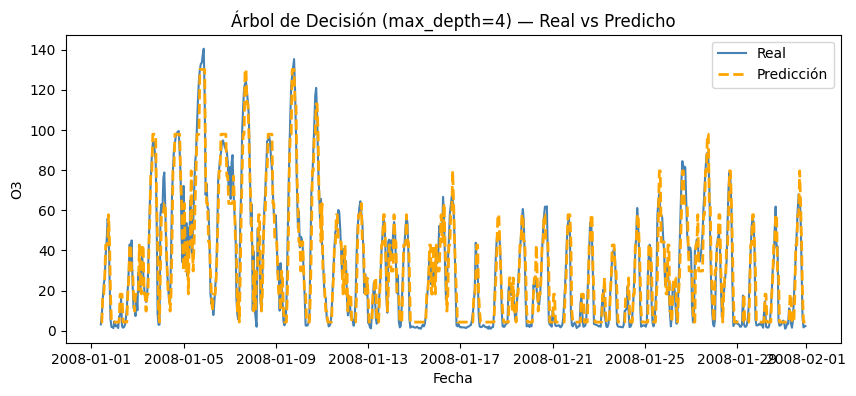

In [ ]:
# === Bloque 8: Integración y prueba de modelado (versión simple) ===
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score  # (opcional) TimeSeriesSplit ver abajo
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit

# 1) Selección de atributos (usa exactamente los que ya has creado)
atributos = [
    'O3_lag1','O3_lag2','O3_lag3','O3_lag4','O3_lag5','O3_lag6','O3_lag7','O3_lag8','O3_lag9','O3_lag10',
    'media_movil_4','max_movil_4','min_movil_4','std_movil_4',
    'media_acum','suma_acum','max_acum','std_acum'
]

X = df_rolling[atributos]
y = df_rolling['O3']

# 2) Eliminar filas con NaN (por lags/ventanas) y alinear índices
X = X.dropna()
y = y.loc[X.index]

# 3) Modelo base (árbol poco profundo para evitar sobreajuste)
model = DecisionTreeRegressor(max_depth=4, random_state=42)

# 4) Para series, mejor TimeSeriesSplit (ver comentario)
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X, y, cv=tscv)
print(f"Rendimiento medio (TimeSeriesSplit, R^2): {scores.mean():.3f}")

#scores = cross_val_score(model, X, y, cv=5)
#print(f"Rendimiento medio (CV=5, R^2): {scores.mean():.3f}")

# 5) Entrenar en todo el conjunto y predecir (solo para visualizar el pipeline)
model.fit(X, y)
y_pred = model.predict(X)

# 6) Visualización: real vs predicho
plt.figure(figsize=(10,4))
plt.plot(y.index, y, label='Real', color='steelblue')
plt.plot(y.index, y_pred, label='Predicción', color='orange', linestyle='--', linewidth=2)
plt.title('Árbol de Decisión (max_depth=4) — Real vs Predicho')
plt.xlabel('Fecha'); plt.ylabel('O3'); plt.legend()
plt.show()

